In [1]:
import joblib
import pickle
from datetime import datetime
from collections import Counter
import re
import string
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words('russian')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 12345

In [3]:
df = pd.read_csv('combined_reviews.csv')
df

,movie_name,date,content,prompt_type,model,is_generated
0,Блеф (1976),2011-09-24,"\n""Блеф» — одна из моих самых любимых комедий....",NaN,NaN,False
1,Блеф (1976),2008-03-04,\nАдриано Челентано продолжает радовать нас св...,NaN,NaN,False
2,Блеф (1976),2007-03-04,"\nНесомненно, это один из великих фильмов 80-х...",NaN,NaN,False
3,Блеф (1976),2009-08-17,\nЭта фраза на мой взгляд отражает сюжет несом...,NaN,NaN,False
4,Блеф (1976),2009-08-20,"\n- как пела Земфира, скорее всего, по соверше...",NaN,NaN,False
...,...,...,...,...,...,...
37636,5 дней в августе (2011),NaN,Фильм пытается показать трагедию войны через с...,short,deepseek/deepseek-v3.2,True
37637,5 дней в августе (2011),NaN,"Картинка красивая, игра актеров неплохая, но с...",medium,deepseek/deepseek-v3.2,True
37638,Цветок дьявола (2010),NaN,"Ожидал большего от триллера с таким названием,...",medium,deepseek/deepseek-v3.2,True
37639,Цветок дьявола (2010),NaN,"Сюжет затянут и предсказуем, а атмосфера, кото...",short,deepseek/deepseek-v3.2,True


In [4]:
df['is_generated'].sum()

np.int64(1050)

In [5]:
df.shape

(37641, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37641 entries, 0 to 37640
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie_name    37641 non-null  object
 1   date          36591 non-null  object
 2   content       37641 non-null  object
 3   prompt_type   1050 non-null   object
 4   model         1050 non-null   object
 5   is_generated  37641 non-null  bool  
dtypes: bool(1), object(5)
memory usage: 1.5+ MB


In [7]:
df.describe()

,movie_name,date,content,prompt_type,model,is_generated
count,37641,36591,37641,1050,1050,37641
unique,350,2643,37628,2,1,2
top,Начало (2010),2010-07-23,\n- Это только мысли в моей голове… Всего за о...,medium,deepseek/deepseek-v3.2,False
freq,1387,125,2,526,1050,36591


In [8]:
df.isnull().sum()

,0
movie_name,0
date,1050
content,0
prompt_type,36591
model,36591
is_generated,0


In [9]:
df['is_generated'].value_counts(normalize=True)

,proportion
is_generated,
False,0.972105
True,0.027895


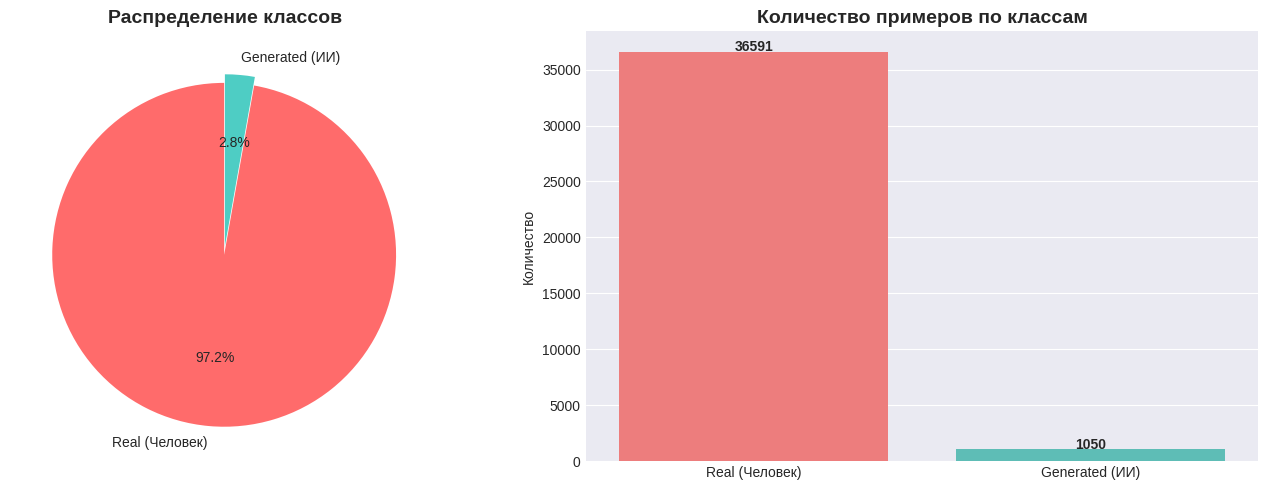

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
class_dist = df['is_generated'].value_counts()
labels = ['Real (Человек)', 'Generated (ИИ)']
colors = ['#FF6B6B', '#4ECDC4']
ax1.pie(class_dist, labels=labels, autopct='%1.1f%%',
        colors=colors, startangle=90, explode=(0.05, 0))
ax1.set_title('Распределение классов', fontsize=14, fontweight='bold')

ax2 = axes[1]
sns.barplot(x=labels, y=class_dist.values, ax=ax2, palette=colors)
ax2.set_title('Количество примеров по классам', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество')
for i, v in enumerate(class_dist.values):
    ax2.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
print("Количество записей на фильм по классам:")
movie_stats = df.groupby(['movie_name', 'is_generated']).size().unstack(fill_value=0)
print(f"Максимальное количество реальных отзывов на фильм: {movie_stats[False].max()}")
print(f"Максимальное количество сгенерированных отзывов на фильм: {movie_stats[True].max()}")
print(f"Минимальное количество реальных отзывов на фильм: {movie_stats[False].min()}")
print(f"Минимальное количество сгенерированных отзывов на фильм: {movie_stats[True].min()}")

Количество записей на фильм по классам:
Максимальное количество реальных отзывов на фильм: 1384
Максимальное количество сгенерированных отзывов на фильм: 3
Минимальное количество реальных отзывов на фильм: 2
Минимальное количество сгенерированных отзывов на фильм: 3


In [12]:
films_with_enough_real = movie_stats[movie_stats[False] >= 3].index.tolist()
films_with_exact_3_generated = movie_stats[movie_stats[True] == 3].index.tolist()
selected_films = list(set(films_with_enough_real) & set(films_with_exact_3_generated))
selected_films

['Мотылек (1973)',
 'Форсаж да Винчи (2007)',
 'Октябрьское небо (1999)',
 'Пираты Карибского моря Проклятие Черной жемчужины (2003)',
 'Ромео и Джульетта (1968)',
 'Операция «Ы» и другие приключения Шурика (1965)',
 'Непрощенный (1992)',
 'Общество мертвых поэтов (1989)',
 'Другие (2001)',
 'Бронкская история (1993)',
 'Slove. Прямо в сердце (2011)',
 'Леон (1994)',
 'Побег из Шоушенка (1994)',
 'Самый лучший фильм 3-ДЭ (2011)',
 'Унесенные ветром (1939)',
 'Пятый элемент (1997)',
 'Блондинка в шоколаде (2006)',
 'Кукарача 3D (2011)',
 'Судьба человека (1959)',
 'Пираты Карибского моря Сундук мертвеца (2006)',
 'Окно во двор (1954)',
 'Однажды на Диком Западе (1968)',
 'Гладиатор (2000)',
 'Один в темноте (2005)',
 'Шестое чувство (1999)',
 'Человек дождя (1988)',
 'Кокаин (2001)',
 'Бриллиантовая рука (1968)',
 'Ржевский против Наполеона (2012)',
 'Секс Гуру (2008)',
 'Блеф (1976)',
 'Король Лев (1994)',
 'Мосты округа Мэдисон (1995)',
 'Шерлок Холмс Игра теней (2011)',
 'Крепкий оре

In [13]:
balanced_data = []

for film in selected_films:
    generated_reviews = df[(df['movie_name'] == film) & (df['is_generated'] == True)]

    if len(generated_reviews) == 0:
        continue

    generated_sample = generated_reviews.head(3)

    real_reviews = df[(df['movie_name'] == film) & (df['is_generated'] == False)]

    if len(real_reviews) >= 3:
        real_sample = real_reviews.sample(n=3, random_state=RANDOM_STATE)
    else:
        real_sample = real_reviews

    balanced_data.append(generated_sample)
    balanced_data.append(real_sample)

balanced_df = pd.concat(balanced_data, ignore_index=True)

In [14]:
balanced_class_dist = balanced_df['is_generated'].value_counts()
print(balanced_class_dist)
print(f"Доля сгенерированных: {balanced_class_dist[True]/len(balanced_df)*100:.1f}%")
print(f"Доля реальных: {balanced_class_dist[False]/len(balanced_df)*100:.1f}%")

is_generated
True     1047
False    1047
Name: count, dtype: int64
Доля сгенерированных: 50.0%
Доля реальных: 50.0%


In [15]:
balanced_movie_stats = balanced_df.groupby(['movie_name', 'is_generated']).size().unstack(fill_value=0)
print(f"\nСтатистика по реальным отзывам на фильм:")
print(f"Максимум: {balanced_movie_stats[False].max()}")
print(f"Минимум: {balanced_movie_stats[False].min()}")
print(f"Среднее: {balanced_movie_stats[False].mean():.2f}")

print(f"\nСтатистика по сгенерированным отзывам на фильм:")
print(f"Максимум: {balanced_movie_stats[True].max()}")
print(f"Минимум: {balanced_movie_stats[True].min()}")
print(f"Среднее: {balanced_movie_stats[True].mean():.2f}")


Статистика по реальным отзывам на фильм:
Максимум: 3
Минимум: 3
Среднее: 3.00

Статистика по сгенерированным отзывам на фильм:
Максимум: 3
Минимум: 3
Среднее: 3.00


In [16]:
balanced_df.to_csv('balanced_movie_reviews.csv', index=False, encoding='utf-8')
df = balanced_df.copy()

In [17]:
df['text_length'] = df['content'].str.len()
df['word_count'] = df['content'].str.split().str.len()

real_stats = df[df['is_generated'] == False]['word_count'].describe()
gen_stats = df[df['is_generated'] == True]['word_count'].describe()

print("\nСтатистика количества слов по классам:")
print("\nРеальные отзывы:")
print(f"  Среднее: {real_stats['mean']:.1f}")
print(f"  Стандартное отклонение: {real_stats['std']:.1f}")
print(f"  Минимум: {real_stats['min']:.0f}")
print(f"  Максимум: {real_stats['max']:.0f}")

print("\nСгенерированные отзывы:")
print(f"  Среднее: {gen_stats['mean']:.1f}")
print(f"  Стандартное отклонение: {gen_stats['std']:.1f}")
print(f"  Минимум: {gen_stats['min']:.0f}")
print(f"  Максимум: {gen_stats['max']:.0f}")


Статистика количества слов по классам:

Реальные отзывы:
  Среднее: 289.8
  Стандартное отклонение: 202.7
  Минимум: 8
  Максимум: 1780

Сгенерированные отзывы:
  Среднее: 20.2
  Стандартное отклонение: 14.1
  Минимум: 1
  Максимум: 289


In [18]:
df['has_date'] = df['date'].notna()
df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')

## EDA

### Анализ даты публикации

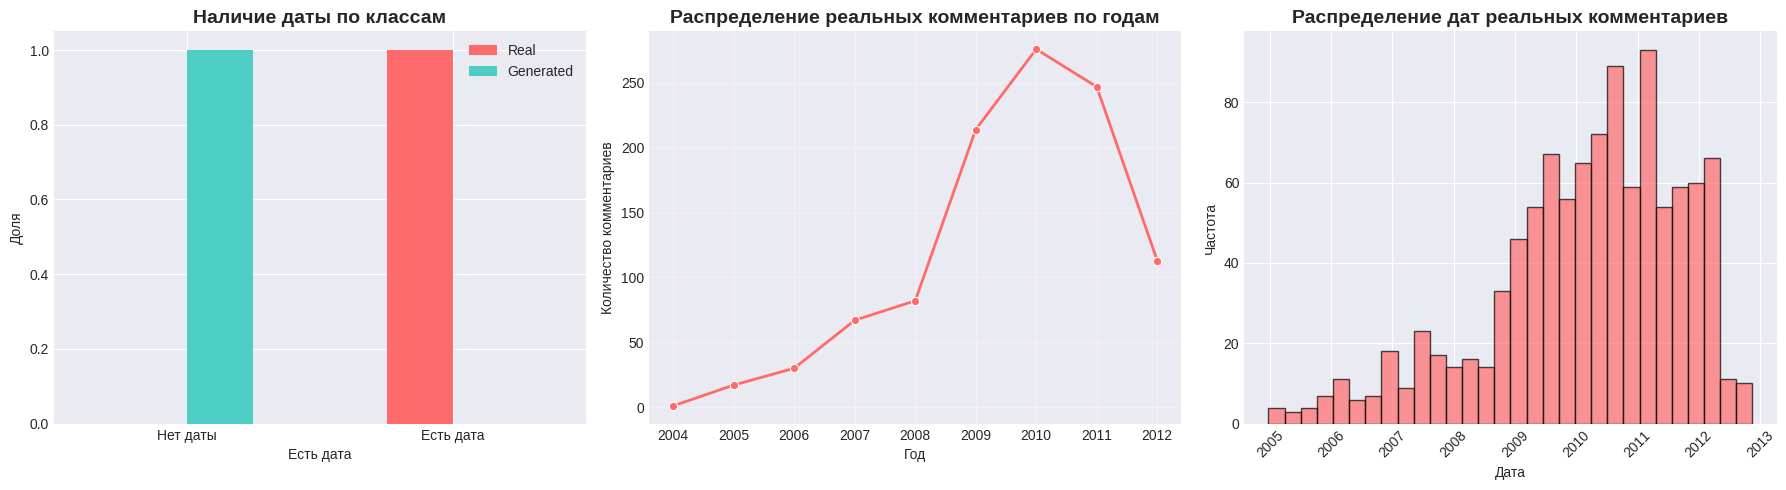

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax1 = axes[0]
date_by_class = pd.crosstab(df['has_date'], df['is_generated'], normalize='columns')
date_by_class.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Наличие даты по классам', fontsize=14, fontweight='bold')
ax1.set_xlabel('Есть дата')
ax1.set_ylabel('Доля')
ax1.legend(['Real', 'Generated'])
ax1.set_xticklabels(['Нет даты', 'Есть дата'], rotation=0)


ax2 = axes[1]
real_comments = df[df['is_generated'] == False].copy()
real_comments['year'] = real_comments['date_parsed'].dt.year
year_counts = real_comments['year'].value_counts().sort_index()
sns.lineplot(x=year_counts.index, y=year_counts.values, ax=ax2,
             color='#FF6B6B', marker='o', linewidth=2)
ax2.set_title('Распределение реальных комментариев по годам',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Год')
ax2.set_ylabel('Количество комментариев')
ax2.grid(True, alpha=0.3)


ax3 = axes[2]
if not real_comments['date_parsed'].isna().all():
    ax3.hist(real_comments['date_parsed'].dropna(), bins=30,
             color='#FF6B6B', edgecolor='black', alpha=0.7)
    ax3.set_title('Распределение дат реальных комментариев',
                  fontsize=14, fontweight='bold')
    ax3.set_xlabel('Дата')
    ax3.set_ylabel('Частота')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Анализ длины текста

In [20]:
df['char_count'] = df['content'].str.len()
df['word_count'] = df['content'].str.split().str.len()
df['sentence_count'] = df['content'].apply(lambda x: len(re.split(r'[.!?]+', str(x))) - 1)
df['avg_word_length'] = df['char_count'] / df['word_count']

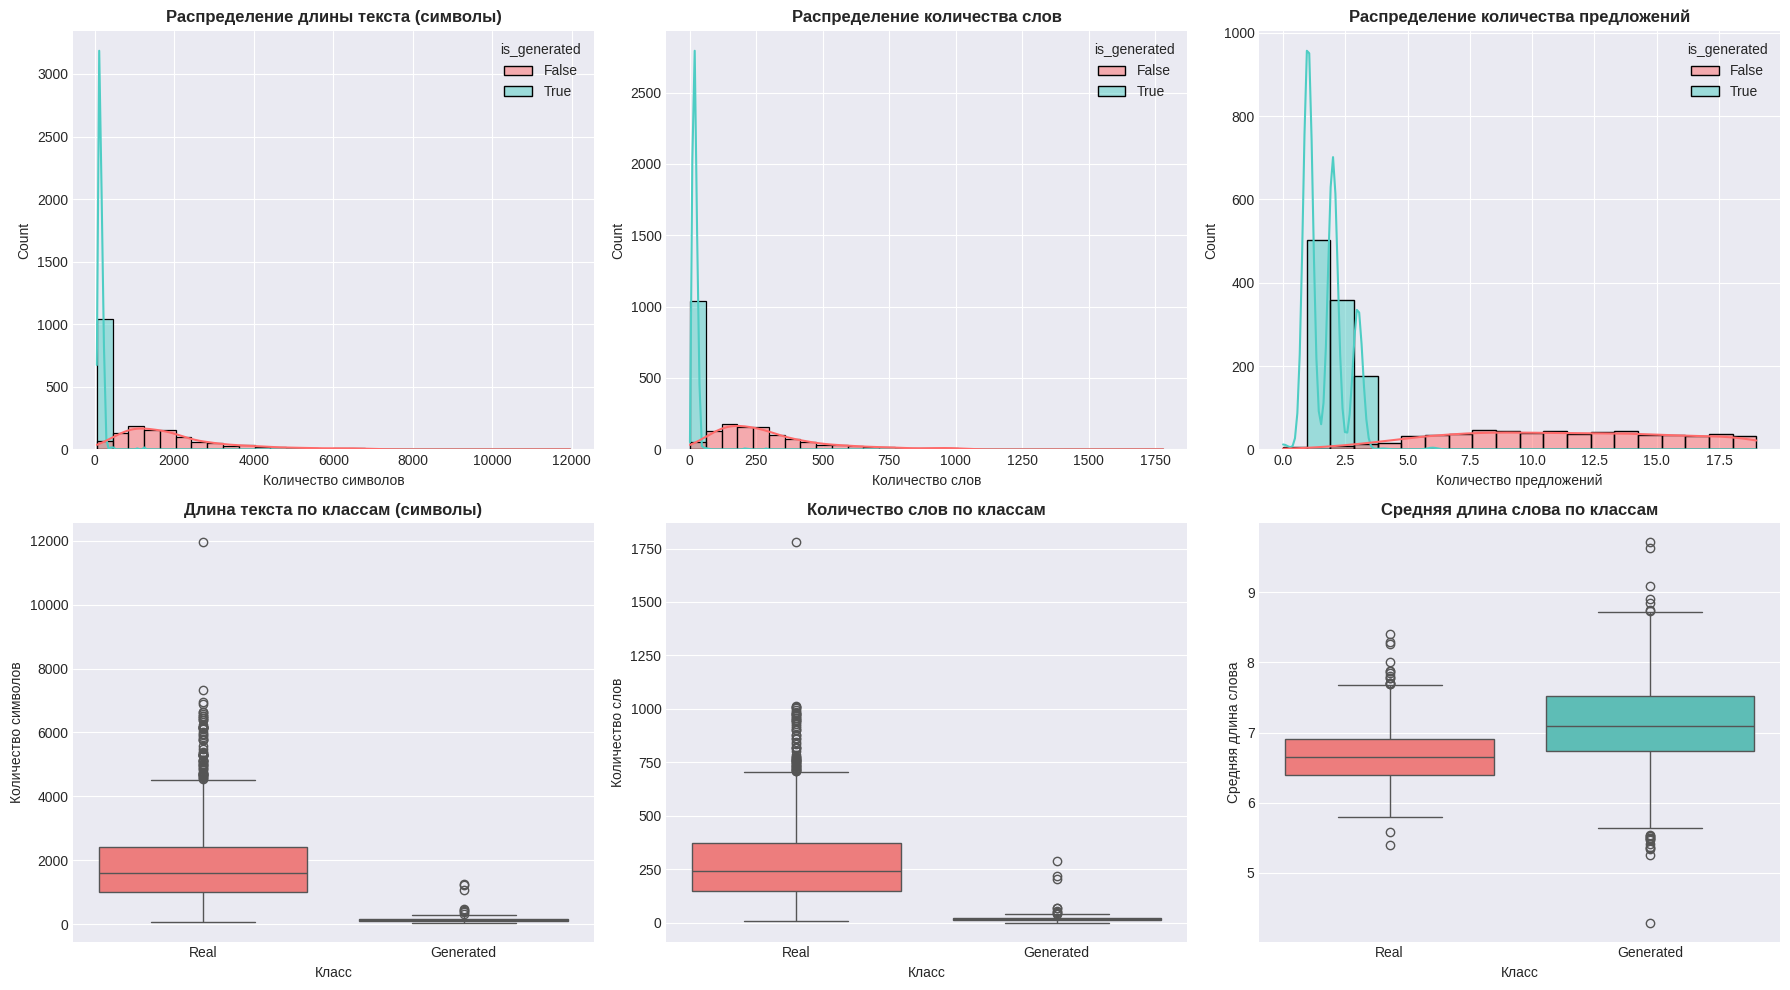

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))


ax1 = axes[0, 0]
sns.histplot(data=df, x='char_count', hue='is_generated',
             bins=30, kde=True, ax=ax1, palette=colors)
ax1.set_title('Распределение длины текста (символы)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Количество символов')


ax2 = axes[0, 1]
sns.histplot(data=df, x='word_count', hue='is_generated',
             bins=30, kde=True, ax=ax2, palette=colors)
ax2.set_title('Распределение количества слов', fontsize=12, fontweight='bold')
ax2.set_xlabel('Количество слов')


ax3 = axes[0, 2]
sns.histplot(data=df[df['sentence_count'] < 20], x='sentence_count',
             hue='is_generated', bins=20, kde=True, ax=ax3, palette=colors)
ax3.set_title('Распределение количества предложений', fontsize=12, fontweight='bold')
ax3.set_xlabel('Количество предложений')


ax4 = axes[1, 0]
sns.boxplot(data=df, x='is_generated', y='char_count', ax=ax4, palette=colors)
ax4.set_title('Длина текста по классам (символы)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Класс')
ax4.set_ylabel('Количество символов')
ax4.set_xticklabels(['Real', 'Generated'])


ax5 = axes[1, 1]
sns.boxplot(data=df, x='is_generated', y='word_count', ax=ax5, palette=colors)
ax5.set_title('Количество слов по классам', fontsize=12, fontweight='bold')
ax5.set_xlabel('Класс')
ax5.set_ylabel('Количество слов')
ax5.set_xticklabels(['Real', 'Generated'])


ax6 = axes[1, 2]
sns.boxplot(data=df[df['avg_word_length'] < 20], x='is_generated',
            y='avg_word_length', ax=ax6, palette=colors)
ax6.set_title('Средняя длина слова по классам', fontsize=12, fontweight='bold')
ax6.set_xlabel('Класс')
ax6.set_ylabel('Средняя длина слова')
ax6.set_xticklabels(['Real', 'Generated'])

plt.tight_layout()
plt.show()

### Анализ лексических особенностей

In [22]:
def analyze_text_features(text):
    if not isinstance(text, str):
        return {
            'punctuation_ratio': 0,
            'uppercase_ratio': 0,
            'stopword_ratio': 0,
            'unique_word_ratio': 0
        }

    words = text.lower().split()
    if len(words) == 0:
        return {
            'punctuation_ratio': 0,
            'uppercase_ratio': 0,
            'stopword_ratio': 0,
            'unique_word_ratio': 0
        }

    punctuation_count = sum(1 for char in text if char in string.punctuation)
    punctuation_ratio = punctuation_count / len(text) if len(text) > 0 else 0

    uppercase_count = sum(1 for char in text if char.isupper())
    uppercase_ratio = uppercase_count / len(text) if len(text) > 0 else 0

    stopword_count = sum(1 for word in words if word in russian_stopwords)
    stopword_ratio = stopword_count / len(words) if len(words) > 0 else 0

    unique_word_ratio = len(set(words)) / len(words) if len(words) > 0 else 0

    return {
        'punctuation_ratio': punctuation_ratio,
        'uppercase_ratio': uppercase_ratio,
        'stopword_ratio': stopword_ratio,
        'unique_word_ratio': unique_word_ratio
    }

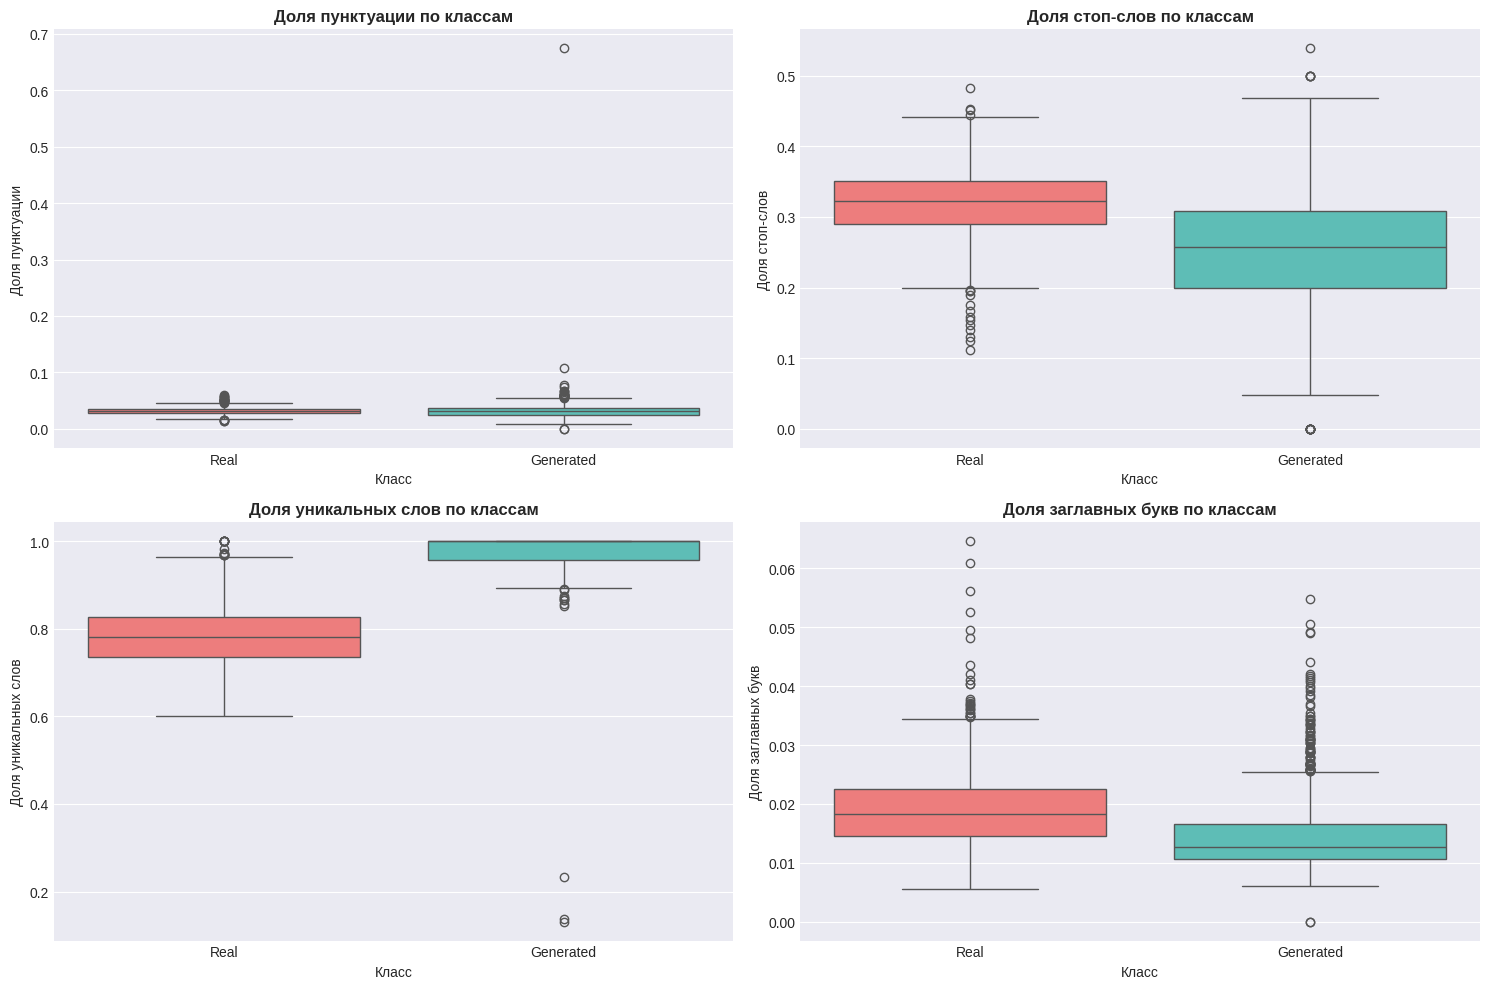

In [23]:
text_features = df['content'].apply(analyze_text_features)
text_features_df = pd.DataFrame(text_features.tolist())
df = pd.concat([df, text_features_df], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax1 = axes[0, 0]
sns.boxplot(data=df, x='is_generated', y='punctuation_ratio',
            ax=ax1, palette=colors)
ax1.set_title('Доля пунктуации по классам', fontsize=12, fontweight='bold')
ax1.set_xlabel('Класс')
ax1.set_ylabel('Доля пунктуации')
ax1.set_xticklabels(['Real', 'Generated'])



ax2 = axes[0, 1]
sns.boxplot(data=df, x='is_generated', y='stopword_ratio',
            ax=ax2, palette=colors)
ax2.set_title('Доля стоп-слов по классам', fontsize=12, fontweight='bold')
ax2.set_xlabel('Класс')
ax2.set_ylabel('Доля стоп-слов')
ax2.set_xticklabels(['Real', 'Generated'])



ax3 = axes[1, 0]
sns.boxplot(data=df, x='is_generated', y='unique_word_ratio',
            ax=ax3, palette=colors)
ax3.set_title('Доля уникальных слов по классам', fontsize=12, fontweight='bold')
ax3.set_xlabel('Класс')
ax3.set_ylabel('Доля уникальных слов')
ax3.set_xticklabels(['Real', 'Generated'])



ax4 = axes[1, 1]
sns.boxplot(data=df, x='is_generated', y='uppercase_ratio',
            ax=ax4, palette=colors)
ax4.set_title('Доля заглавных букв по классам', fontsize=12, fontweight='bold')
ax4.set_xlabel('Класс')
ax4.set_ylabel('Доля заглавных букв')
ax4.set_xticklabels(['Real', 'Generated'])


plt.tight_layout()
plt.show()

### Анализ наиболее частых слов

In [24]:
additional_stopwords = {
    'фильм', 'фильма', 'фильме', 'фильму', 'фильмов',
    'это', 'этого', 'этом', 'эту', 'эти', 'этим',
    'который', 'которая', 'которые', 'которых',
    'весь', 'вся', 'всё', 'всех',
    'очень', 'просто', 'даже', 'уже', 'еще',
    'был', 'была', 'было', 'были',
    'нет', 'не', 'ни', 'ну', 'как', 'так',
    'только', 'очень', 'можно', 'есть',
    'мне', 'меня', 'мной', 'моя', 'мой',
    'наш', 'наша', 'наше', 'наши',
    'ваш', 'ваша', 'ваше', 'ваши',
    'свой', 'своя', 'своё', 'свои',
    'что', 'чтобы', 'когда', 'где', 'куда',
    'от', 'до', 'для', 'из', 'на', 'по', 'со',
    'а', 'и', 'но', 'или', 'то', 'же'
}

In [25]:
russian_stopwords = set(russian_stopwords)

all_stopwords = russian_stopwords.union(additional_stopwords)

In [26]:
def clean_text_for_wordcloud(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)

    return text.strip()


def remove_stopwords(text, stopwords_set):
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords_set and len(word) > 2]
    return ' '.join(filtered_words)


def get_top_words_advanced(text, n=30, min_word_length=3):
    words = text.lower().split()
    filtered_words = [word for word in words
                     if word not in all_stopwords
                     and len(word) >= min_word_length]
    word_freq = Counter(filtered_words)

    return word_freq.most_common(n)


def get_top_bigrams(text, n=20):
    words = text.split()
    bigrams = [(words[i], words[i+1]) for i in range(len(words)-1)]

    filtered_bigrams = []
    for w1, w2 in bigrams:
        if (w1 not in all_stopwords and len(w1) > 2 and
            w2 not in all_stopwords and len(w2) > 2):
            filtered_bigrams.append(f"{w1} {w2}")

    return Counter(filtered_bigrams).most_common(n)


def calculate_lexical_diversity(text):
    words = text.split()
    if len(words) == 0:
        return 0, 0

    unique_words = set(words)
    ttr = len(unique_words) / len(words)
    word_counts = Counter(words)
    hapax_count = sum(1 for count in word_counts.values() if count == 1)
    hapax_ratio = hapax_count / len(words)

    return ttr, hapax_ratio

In [27]:
generated_texts_raw = ' '.join(df[df['is_generated'] == True]['content'].astype(str).tolist())
real_texts_raw = ' '.join(df[df['is_generated'] == False]['content'].astype(str).tolist())

real_texts_clean = clean_text_for_wordcloud(real_texts_raw)
generated_texts_clean = clean_text_for_wordcloud(generated_texts_raw)

real_texts_no_stopwords = remove_stopwords(real_texts_clean, all_stopwords)
generated_texts_no_stopwords = remove_stopwords(generated_texts_clean, all_stopwords)

In [28]:
print(f"Длина реальных текстов до очистки: {len(real_texts_raw.split())} слов")
print(f"Длина реальных текстов после очистки: {len(real_texts_no_stopwords.split())} слов")
print(f"Длина сгенерированных текстов до очистки: {len(generated_texts_raw.split())} слов")
print(f"Длина сгенерированных текстов после очистки: {len(generated_texts_no_stopwords.split())} слов")

Длина реальных текстов до очистки: 303447 слов
Длина реальных текстов после очистки: 178962 слов
Длина сгенерированных текстов до очистки: 21159 слов
Длина сгенерированных текстов после очистки: 13877 слов


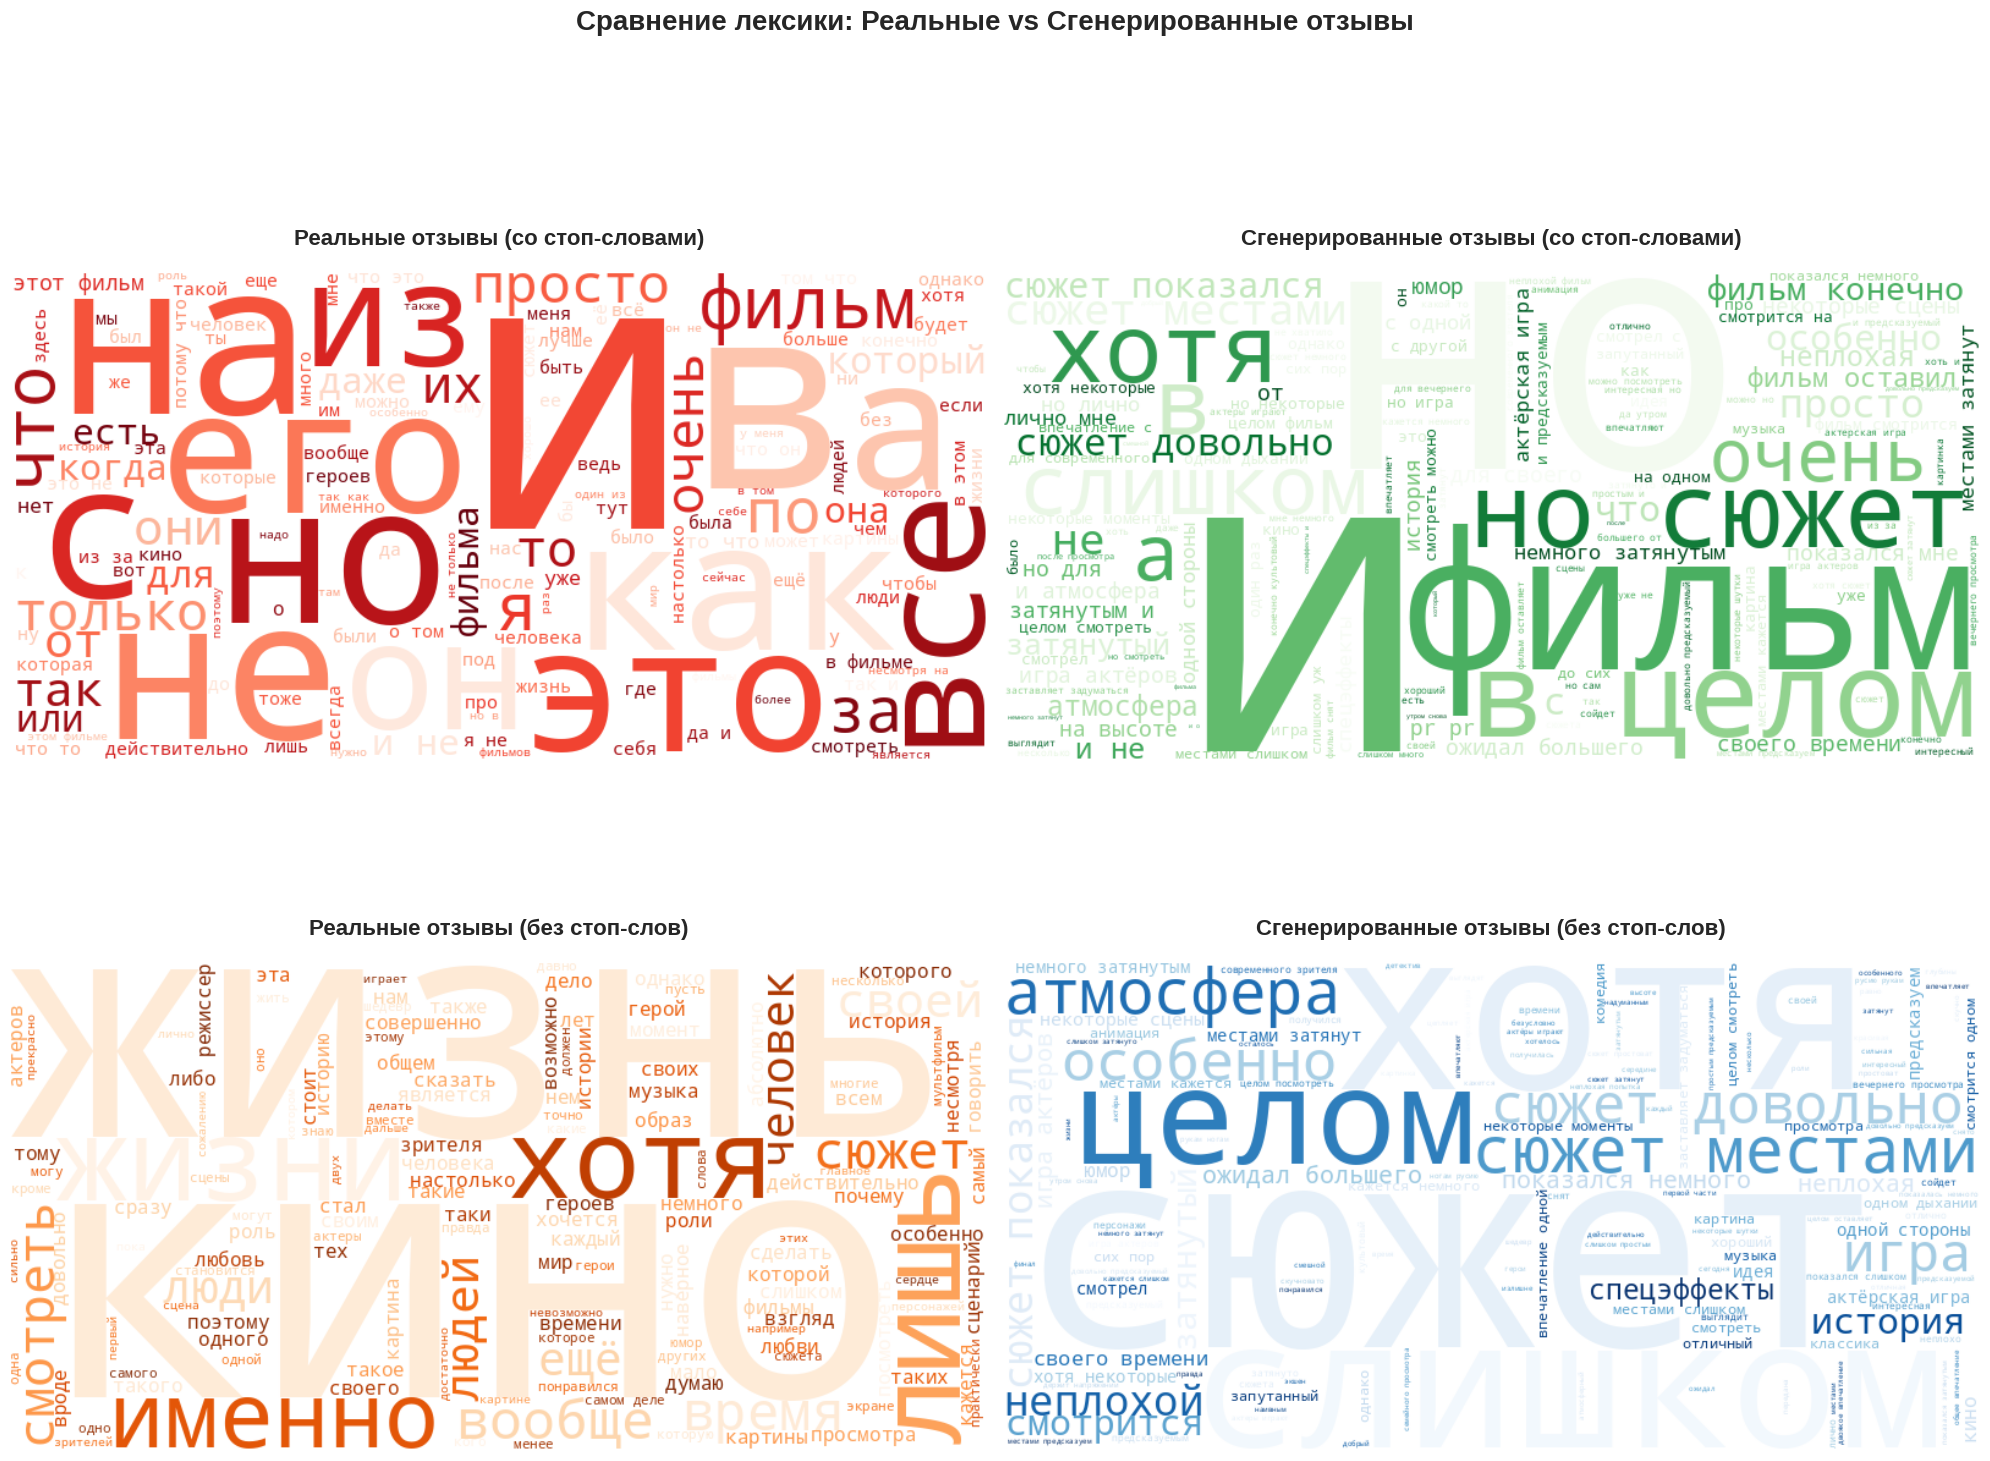

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

ax1 = axes[0, 0]
wordcloud_real_raw = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=150,
    contour_width=1,
    contour_color='darkred',
    random_state=42
).generate(real_texts_clean)
ax1.imshow(wordcloud_real_raw, interpolation='bilinear')
ax1.set_title('Реальные отзывы (со стоп-словами)', fontsize=16, fontweight='bold', pad=20)
ax1.axis('off')



ax2 = axes[0, 1]
wordcloud_gen_raw = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens',
    max_words=150,
    contour_width=1,
    contour_color='darkgreen',
    random_state=42
).generate(generated_texts_clean)
ax2.imshow(wordcloud_gen_raw, interpolation='bilinear')
ax2.set_title('Сгенерированные отзывы (со стоп-словами)', fontsize=16, fontweight='bold', pad=20)
ax2.axis('off')



ax3 = axes[1, 0]
wordcloud_real_clean = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Oranges',
    max_words=150,
    contour_width=1,
    contour_color='darkorange',
    random_state=42
).generate(real_texts_no_stopwords)
ax3.imshow(wordcloud_real_clean, interpolation='bilinear')
ax3.set_title('Реальные отзывы (без стоп-слов)', fontsize=16, fontweight='bold', pad=20)
ax3.axis('off')



ax4 = axes[1, 1]
wordcloud_gen_clean = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues',
    max_words=150,
    contour_width=1,
    contour_color='darkblue',
    random_state=42
).generate(generated_texts_no_stopwords)
ax4.imshow(wordcloud_gen_clean, interpolation='bilinear')
ax4.set_title('Сгенерированные отзывы (без стоп-слов)', fontsize=16, fontweight='bold', pad=20)
ax4.axis('off')

plt.suptitle('Сравнение лексики: Реальные vs Сгенерированные отзывы',
             fontsize=20, fontweight='bold', y=1.02)


plt.tight_layout()
plt.show()

In [30]:
top_real = get_top_words_advanced(real_texts_no_stopwords, n=30)
top_generated = get_top_words_advanced(generated_texts_no_stopwords, n=30)

In [31]:
print("Топ-30 слов в реальных отзывах:")
for i, (word, freq) in enumerate(top_real, 1):
    print(f"{i:2}. {word:15} - {freq:5} раз")

print("Топ-30 слов в сгенерированных отзывах:")
for i, (word, freq) in enumerate(top_generated, 1):
    print(f"{i:2}. {word:15} - {freq:5} раз")

Топ-30 слов в реальных отзывах:
 1. кино            -   633 раз
 2. жизни           -   446 раз
 3. время           -   430 раз
 4. жизнь           -   421 раз
 5. лишь            -   376 раз
 6. хотя            -   376 раз
 7. смотреть        -   367 раз
 8. своей           -   357 раз
 9. именно          -   351 раз
10. сказать         -   322 раз
11. вообще          -   320 раз
12. сюжет           -   317 раз
13. фильмы          -   299 раз
14. людей           -   298 раз
15. каждый          -   281 раз
16. стоит           -   256 раз
17. история         -   256 раз
18. люди            -   255 раз
19. человек         -   254 раз
20. человека        -   253 раз
21. эта             -   250 раз
22. роль            -   249 раз
23. просмотра       -   247 раз
24. нам             -   242 раз
25. нужно           -   241 раз
26. всем            -   240 раз
27. действительно   -   231 раз
28. ещё             -   230 раз
29. посмотреть      -   216 раз
30. героев          -   215 раз
Топ-30 с

In [32]:
real_df = pd.DataFrame(top_real, columns=['word', 'real_freq'])
gen_df = pd.DataFrame(top_generated, columns=['word', 'gen_freq'])

In [33]:
comparison_df = pd.merge(real_df, gen_df, on='word', how='outer').fillna(0)
comparison_df['total_freq'] = comparison_df['real_freq'] + comparison_df['gen_freq']
comparison_df['real_ratio'] = comparison_df['real_freq'] / comparison_df['total_freq'].replace(0, 1)
comparison_df['gen_ratio'] = comparison_df['gen_freq'] / comparison_df['total_freq'].replace(0, 1)
comparison_df['preference'] = comparison_df.apply(
    lambda x: 'REAL' if x['real_ratio'] > 0.7 else ('AI' if x['gen_ratio'] > 0.7 else 'NEUTRAL'),
    axis=1
)

In [34]:
real_specific = comparison_df[
    (comparison_df['preference'] == 'REAL') &
    (comparison_df['real_freq'] > 10)
].sort_values('real_ratio', ascending=False).head(20)

print("Слова, характерные для РЕАЛЬНЫХ отзывов:")
print(real_specific[['word', 'real_freq', 'gen_freq', 'real_ratio']].to_string(index=False))

ai_specific = comparison_df[
    (comparison_df['preference'] == 'AI') &
    (comparison_df['gen_freq'] > 10)
].sort_values('gen_ratio', ascending=False).head(20)

print("Слова, характерные для СГЕНЕРИРОВАННЫХ отзывов:")
print(ai_specific[['word', 'real_freq', 'gen_freq', 'gen_ratio']].to_string(index=False))

Слова, характерные для РЕАЛЬНЫХ отзывов:
         word  real_freq  gen_freq  real_ratio
       вообще      320.0       0.0         1.0
        время      430.0       0.0         1.0
         всем      240.0       0.0         1.0
       героев      215.0       0.0         1.0
действительно      231.0       0.0         1.0
          ещё      230.0       0.0         1.0
        жизни      446.0       0.0         1.0
        жизнь      421.0       0.0         1.0
       именно      351.0       0.0         1.0
       каждый      281.0       0.0         1.0
        людей      298.0       0.0         1.0
         лишь      376.0       0.0         1.0
     человека      253.0       0.0         1.0
      сказать      322.0       0.0         1.0
         люди      255.0       0.0         1.0
          нам      242.0       0.0         1.0
        нужно      241.0       0.0         1.0
   посмотреть      216.0       0.0         1.0
         роль      249.0       0.0         1.0
        своей      

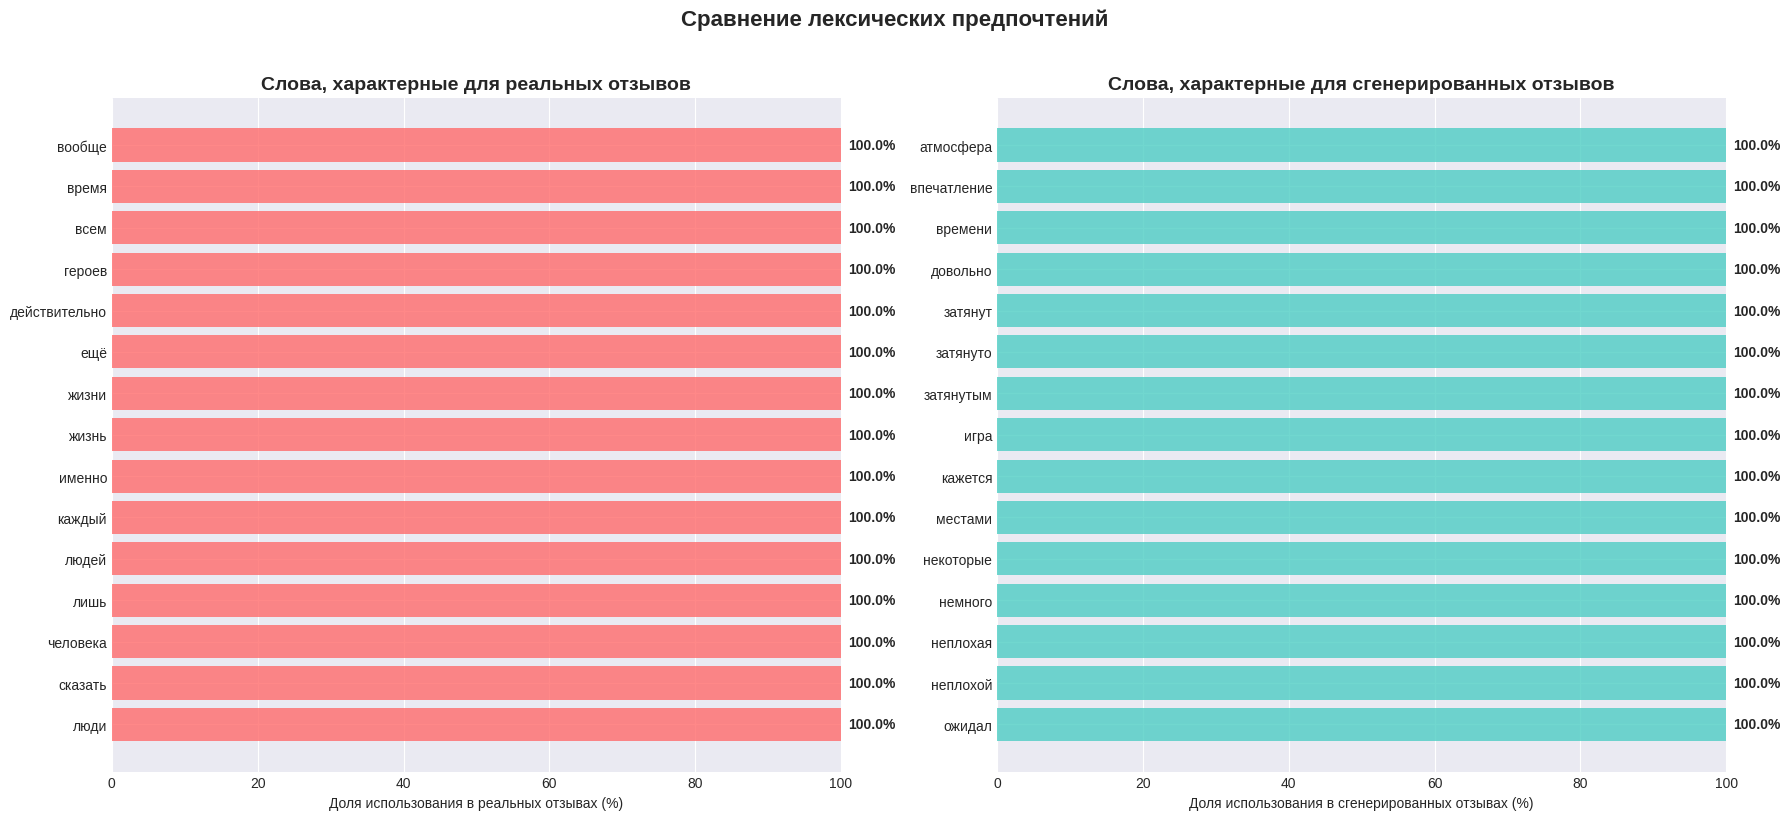

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))


ax1 = axes[0]
top_words_real = real_specific.head(15)
bars1 = ax1.barh(range(len(top_words_real)), top_words_real['real_ratio'].values * 100,
                color='#FF6B6B', alpha=0.8)
ax1.set_yticks(range(len(top_words_real)))
ax1.set_yticklabels(top_words_real['word'].values)
ax1.set_xlabel('Доля использования в реальных отзывах (%)')
ax1.set_title('Слова, характерные для реальных отзывов', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.set_xlim(0, 100)


for i, (bar, ratio) in enumerate(zip(bars1, top_words_real['real_ratio'].values * 100)):
    ax1.text(ratio + 1, i, f'{ratio:.1f}%', va='center', fontweight='bold')


ax2 = axes[1]
top_words_gen = ai_specific.head(15)
bars2 = ax2.barh(range(len(top_words_gen)), top_words_gen['gen_ratio'].values * 100,
                color='#4ECDC4', alpha=0.8)
ax2.set_yticks(range(len(top_words_gen)))
ax2.set_yticklabels(top_words_gen['word'].values)
ax2.set_xlabel('Доля использования в сгенерированных отзывах (%)')
ax2.set_title('Слова, характерные для сгенерированных отзывов', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.set_xlim(0, 100)


for i, (bar, ratio) in enumerate(zip(bars2, top_words_gen['gen_ratio'].values * 100)):
    ax2.text(ratio + 1, i, f'{ratio:.1f}%', va='center', fontweight='bold')

plt.suptitle('Сравнение лексических предпочтений', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [36]:
bigrams_real = get_top_bigrams(real_texts_no_stopwords, n=15)
bigrams_gen = get_top_bigrams(generated_texts_no_stopwords, n=15)

In [37]:
print("Топ-15 биграмм в реальных отзывах:")
for i, (bigram, freq) in enumerate(bigrams_real, 1):
    print(f"{i:2}. {bigram:30} - {freq:5} раз")

print("Топ-15 биграмм в сгенерированных отзывах:")
for i, (bigram, freq) in enumerate(bigrams_gen, 1):
    print(f"{i:2}. {bigram:30} - {freq:5} раз")

Топ-15 биграмм в реальных отзывах:
 1. самом деле                     -   100 раз
 2. главного героя                 -    78 раз
 3. главный герой                  -    77 раз
 4. могу сказать                   -    47 раз
 5. сих пор                        -    45 раз
 6. главных героев                 -    44 раз
 7. друг друга                     -    43 раз
 8. игра актеров                   -    40 раз
 9. самое главное                  -    39 раз
10. такие фильмы                   -    39 раз
11. первой части                   -    39 раз
12. первую очередь                 -    36 раз
13. операторская работа            -    33 раз
14. честно говоря                  -    33 раз
15. крайней мере                   -    32 раз
Топ-15 биграмм в сгенерированных отзывах:
 1. сюжет местами                  -    87 раз
 2. сюжет довольно                 -    64 раз
 3. сюжет показался                -    57 раз
 4. ожидал большего                -    41 раз
 5. показался немного         

In [38]:
ttr_real, hapax_real = calculate_lexical_diversity(real_texts_no_stopwords)
ttr_gen, hapax_gen = calculate_lexical_diversity(generated_texts_no_stopwords)

In [39]:
print(f"Лексическое разнообразие (Type-Token Ratio):")
print(f"  Реальные отзывы:     {ttr_real:.4f}")
print(f"  Сгенерированные:     {ttr_gen:.4f}")
print(f"  Разница:            {abs(ttr_real - ttr_gen):.4f}")

print(f"Доля уникальных слов (встречающихся 1 раз):")
print(f"  Реальные отзывы:     {hapax_real:.4f}")
print(f"  Сгенерированные:     {hapax_gen:.4f}")
print(f"  Разница:            {abs(hapax_real - hapax_gen):.4f}")

Лексическое разнообразие (Type-Token Ratio):
  Реальные отзывы:     0.2562
  Сгенерированные:     0.2474
  Разница:            0.0088
Доля уникальных слов (встречающихся 1 раз):
  Реальные отзывы:     0.1523
  Сгенерированные:     0.1418
  Разница:            0.0105


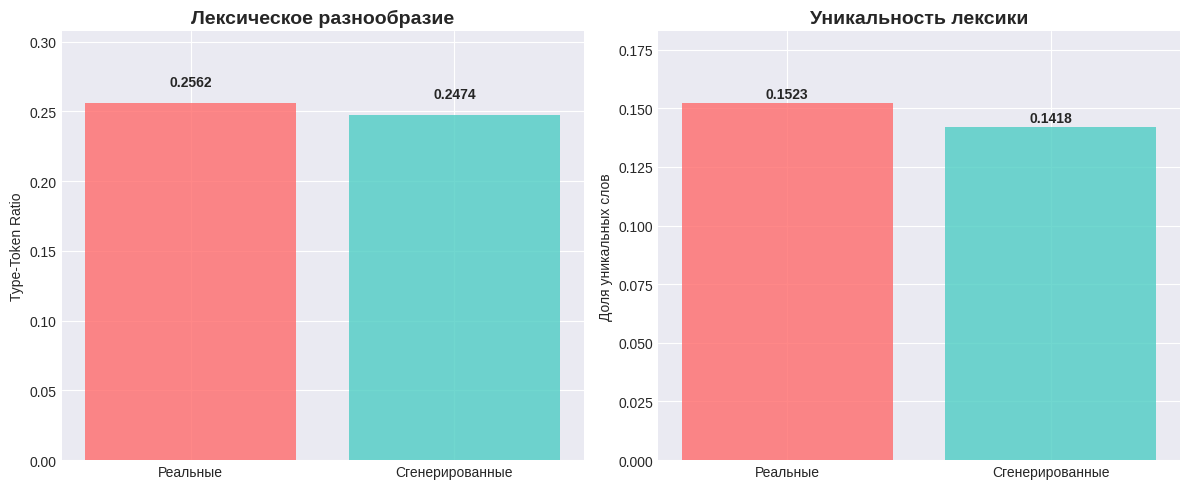

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
categories = ['Реальные', 'Сгенерированные']
ttr_values = [ttr_real, ttr_gen]
colors = ['#FF6B6B', '#4ECDC4']

bars1 = ax1.bar(categories, ttr_values, color=colors, alpha=0.8)
ax1.set_ylabel('Type-Token Ratio')
ax1.set_title('Лексическое разнообразие', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(ttr_values) * 1.2)


for bar, value in zip(bars1, ttr_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.4f}', ha='center', va='bottom', fontweight='bold')


ax2 = axes[1]
hapax_values = [hapax_real, hapax_gen]

bars2 = ax2.bar(categories, hapax_values, color=colors, alpha=0.8)
ax2.set_ylabel('Доля уникальных слов')
ax2.set_title('Уникальность лексики', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(hapax_values) * 1.2)


for bar, value in zip(bars2, hapax_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Корреляционный анализ

In [41]:
numeric_features = ['char_count', 'word_count', 'sentence_count',
                   'avg_word_length', 'punctuation_ratio',
                   'uppercase_ratio', 'stopword_ratio', 'unique_word_ratio']

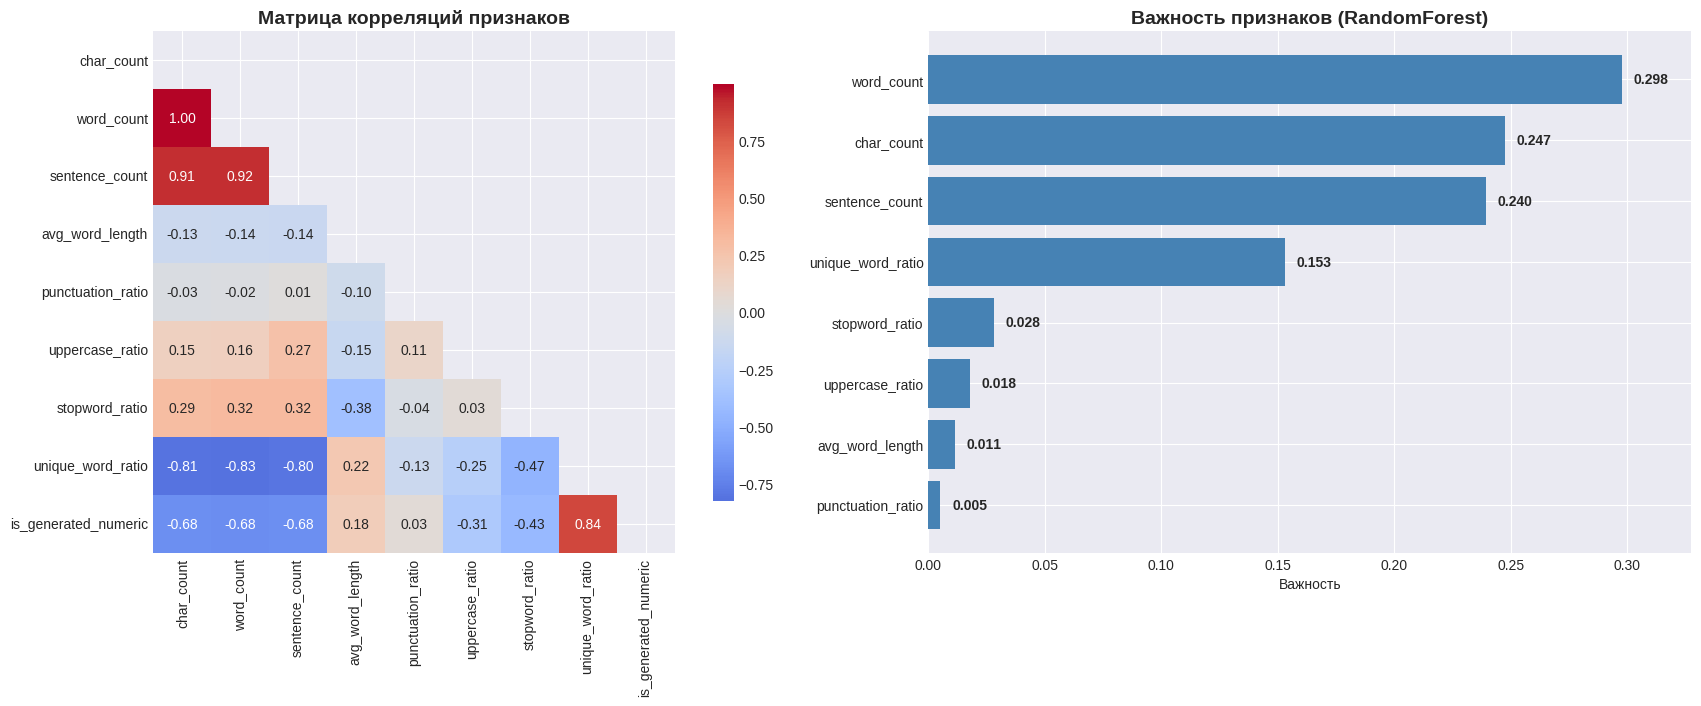

In [42]:
df['is_generated_numeric'] = df['is_generated'].astype(int)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))


ax1 = axes[0]
correlation_matrix = df[numeric_features + ['is_generated_numeric']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, ax=ax1, square=True,
            cbar_kws={"shrink": .8})
ax1.set_title('Матрица корреляций признаков', fontsize=14, fontweight='bold')



X_temp = df[numeric_features].fillna(0)
y_temp = df['is_generated_numeric']

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=RANDOM_STATE, stratify=y_temp
)

rf_temp = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_temp.fit(X_train_temp, y_train_temp)

feature_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=True)

ax2 = axes[1]
bars = ax2.barh(feature_importance['feature'], feature_importance['importance'],
                color='steelblue')
ax2.set_title('Важность признаков (RandomForest)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Важность')
ax2.set_xlim(0, max(feature_importance['importance']) * 1.1)


for i, (bar, imp) in enumerate(zip(bars, feature_importance['importance'])):
    ax2.text(imp + 0.005, bar.get_y() + bar.get_height()/2,
             f'{imp:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Статистические тесты

In [43]:
alpha = .05

#### Сгенерированные тексты имеют другую длину

In [44]:
real_lengths = df[df['is_generated'] == False]['word_count'].dropna()
gen_lengths = df[df['is_generated'] == True]['word_count'].dropna()

t_stat, p_value = stats.ttest_ind(real_lengths, gen_lengths, equal_var=False)
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.10f}")
print(f"ЗНАЧИМАЯ РАЗНИЦА: {'ДА' if p_value < alpha else 'НЕТ'}")
print(f"Средняя длина реальных: {real_lengths.mean():.2f} слов")
print(f"Средняя длина сгенерированных: {gen_lengths.mean():.2f} слов")

t-статистика: 42.9438
p-value: 0.0000000000
ЗНАЧИМАЯ РАЗНИЦА: ДА
Средняя длина реальных: 289.83 слов
Средняя длина сгенерированных: 20.21 слов


#### Разная доля стоп-слов

In [45]:
real_stop = df[df['is_generated'] == False]['stopword_ratio'].dropna()
gen_stop = df[df['is_generated'] == True]['stopword_ratio'].dropna()

t_stat, p_value = stats.ttest_ind(real_stop, gen_stop, equal_var=False)
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.10f}")
print(f"ЗНАЧИМАЯ РАЗНИЦА: {'ДА' if p_value < alpha else 'НЕТ'}")
print(f"Средняя доля стоп-слов (реальные): {real_stop.mean():.4f}")
print(f"Средняя доля стоп-слов (сгенерированные): {gen_stop.mean():.4f}")

t-статистика: 21.7271
p-value: 0.0000000000
ЗНАЧИМАЯ РАЗНИЦА: ДА
Средняя доля стоп-слов (реальные): 0.3206
Средняя доля стоп-слов (сгенерированные): 0.2562


#### Разная лексическая разнообразность

In [46]:
real_unique = df[df['is_generated'] == False]['unique_word_ratio'].dropna()
gen_unique = df[df['is_generated'] == True]['unique_word_ratio'].dropna()

t_stat, p_value = stats.ttest_ind(real_unique, gen_unique, equal_var=False)
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.10f}")
print(f"ЗНАЧИМАЯ РАЗНИЦА: {'ДА' if p_value < alpha else 'НЕТ'}")
print(f"Доля уникальных слов (реальные): {real_unique.mean():.4f}")
print(f"Доля уникальных слов (сгенерированные): {gen_unique.mean():.4f}")

t-статистика: -70.4748
p-value: 0.0000000000
ЗНАЧИМАЯ РАЗНИЦА: ДА
Доля уникальных слов (реальные): 0.7840
Доля уникальных слов (сгенерированные): 0.9763


#### Разное использование пунктуации

In [47]:
real_punct = df[df['is_generated'] == False]['punctuation_ratio'].dropna()
gen_punct = df[df['is_generated'] == True]['punctuation_ratio'].dropna()

t_stat, p_value = stats.ttest_ind(real_punct, gen_punct, equal_var=False)
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.10f}")
print(f"ЗНАЧИМАЯ РАЗНИЦА: {'ДА' if p_value < alpha else 'НЕТ'}")
print(f"Доля пунктуации (реальные): {real_punct.mean():.4f}")
print(f"Доля пунктуации (сгенерированные): {gen_punct.mean():.4f}")

t-статистика: -1.4592
p-value: 0.1447640931
ЗНАЧИМАЯ РАЗНИЦА: НЕТ
Доля пунктуации (реальные): 0.0313
Доля пунктуации (сгенерированные): 0.0323


## Подготовка данных

In [48]:
def clean_text(text):

    if not isinstance(text, str):
        return ""

    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,!?;:-]', '', text)
    text = text.lower()
    text = text.strip()

    return text

In [49]:
df['content_clean'] = df['content'].apply(clean_text)
df = df[df['content_clean'].str.len() > 10]
df['is_generated'].value_counts(normalize=True)

,proportion
is_generated,
True,0.5
False,0.5


In [50]:
X = df[['content_clean', 'char_count', 'word_count', 'punctuation_ratio',
        'stopword_ratio', 'unique_word_ratio']]
y = df['is_generated']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

## Обучение модели

In [51]:
russian_stopwords_list = list(russian_stopwords)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            min_df=5,
            max_df=0.9,
            stop_words=russian_stopwords_list
        ), 'content_clean'),
        ('num', StandardScaler(), ['char_count', 'word_count',
                                   'punctuation_ratio', 'stopword_ratio',
                                   'unique_word_ratio'])
    ]
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=0.1,
        max_iter=1000,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        solver='liblinear'
    ))
])

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

In [52]:
print(f"Средняя точность на кросс-валидации: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Оценки по фолдам: {cv_scores}")

Средняя точность на кросс-валидации: 0.9701 (+/- 0.0053)
Оценки по фолдам: [0.9641791  0.97313433 0.96716418 0.97910448 0.96716418]


In [53]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [54]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Generated']))

Accuracy: 0.9618
ROC-AUC: 0.9849

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.93      0.96       210
   Generated       0.94      0.99      0.96       209

    accuracy                           0.96       419
   macro avg       0.96      0.96      0.96       419
weighted avg       0.96      0.96      0.96       419



Confusion Matrix:
[[196  14]
 [  2 207]]


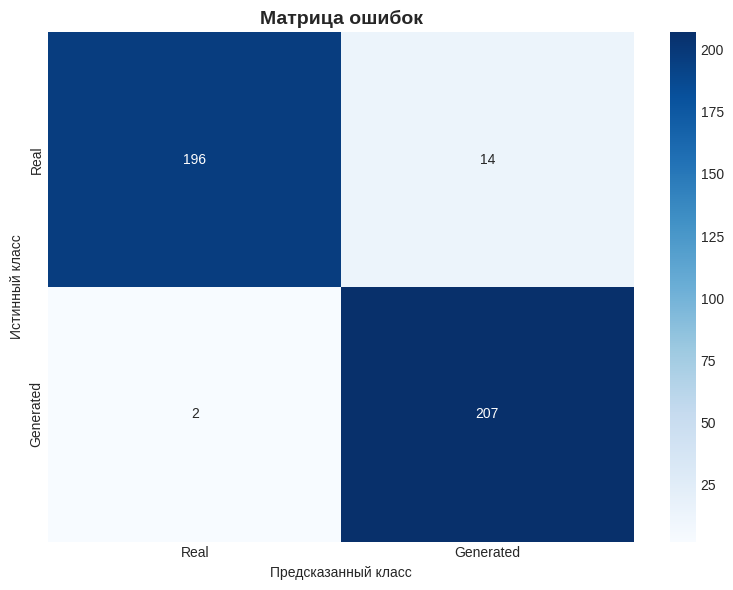

In [55]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Real', 'Generated'],
            yticklabels=['Real', 'Generated'])
ax.set_title('Матрица ошибок', fontsize=14, fontweight='bold')
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
plt.tight_layout()
plt.show()

In [56]:
tfidf_features = model.named_steps['preprocessor'].named_transformers_['text'].get_feature_names_out()
all_features = list(tfidf_features) + ['char_count', 'word_count',
                                       'punctuation_ratio', 'stopword_ratio',
                                       'unique_word_ratio']

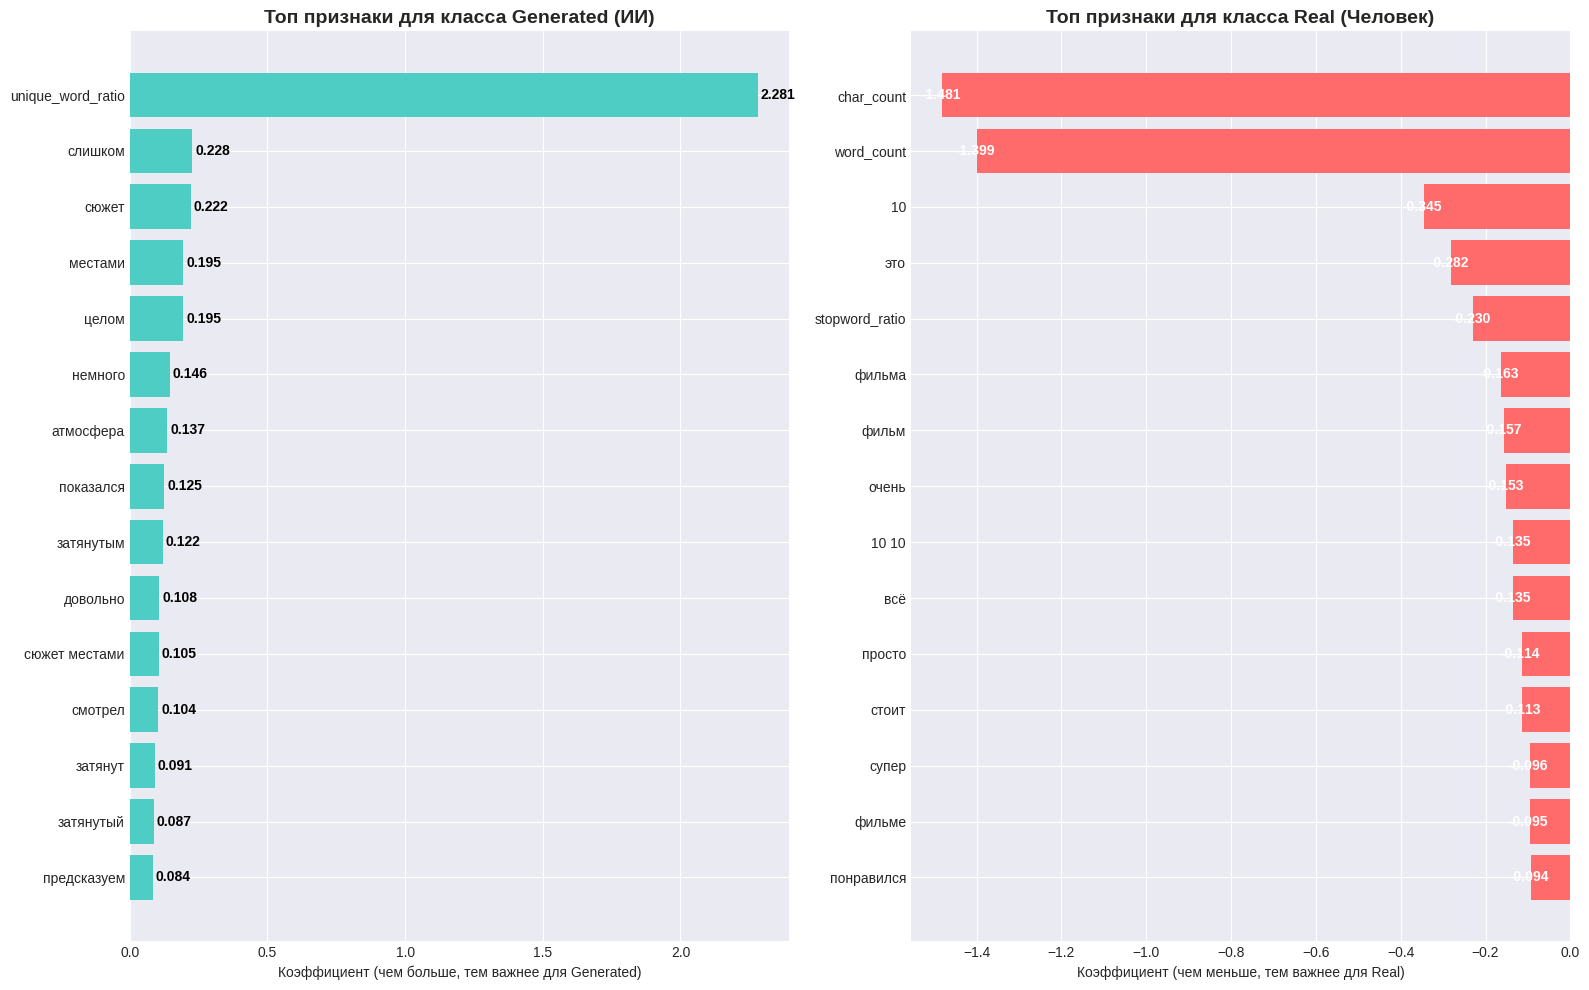

In [57]:
coefficients = model.named_steps['classifier'].coef_[0]

feature_importance = pd.DataFrame({
    'feature': all_features,
    'coefficient': coefficients
})

feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

ax1 = axes[0]
top_gen = feature_importance.sort_values('coefficient', ascending=False).head(15)
bars1 = ax1.barh(range(len(top_gen)), top_gen['coefficient'].values, color='#4ECDC4')
ax1.set_yticks(range(len(top_gen)))
ax1.set_yticklabels(top_gen['feature'].values)
ax1.set_title('Топ признаки для класса Generated (ИИ)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Коэффициент (чем больше, тем важнее для Generated)')
ax1.invert_yaxis()

for i, (bar, coeff) in enumerate(zip(bars1, top_gen['coefficient'].values)):
    ax1.text(coeff + (0.01 if coeff > 0 else -0.05), i,
            f'{coeff:.3f}', va='center',
            color='black' if coeff > 0 else 'white',
            fontweight='bold')

ax2 = axes[1]
top_real = feature_importance.sort_values('coefficient', ascending=True).head(15)
bars2 = ax2.barh(range(len(top_real)), top_real['coefficient'].values, color='#FF6B6B')
ax2.set_yticks(range(len(top_real)))
ax2.set_yticklabels(top_real['feature'].values)
ax2.set_title('Топ признаки для класса Real (Человек)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Коэффициент (чем меньше, тем важнее для Real)')
ax2.invert_yaxis()

for i, (bar, coeff) in enumerate(zip(bars2, top_real['coefficient'].values)):
    ax2.text(coeff + (-0.05 if coeff < 0 else 0.01), i,
            f'{coeff:.3f}', va='center',
            color='white' if coeff < 0 else 'black',
            fontweight='bold')

plt.tight_layout()
plt.show()

In [58]:
joblib.dump(model, 'ai_text_classifier_pipeline.pkl')
vectorizer = model.named_steps['preprocessor'].named_transformers_['text']
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
scaler = model.named_steps['preprocessor'].named_transformers_['num']
joblib.dump(scaler, 'feature_scaler.pkl')

with open('russian_stopwords.pkl', 'wb') as f:
    pickle.dump(all_stopwords, f)